In [1]:
import memoized # poczytaj co to sa dekoratory
import pandas as pd
from Bio.KEGG import REST
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'memoized'

In [2]:
from rossmann_toolbox import RossmannToolbox

/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 from PyObject
  return f(*args, **kwds)
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: greenlet.greenlet size changed, may indicate binary incompatibility. Expected 144 from C header, got 152 

### Get genomes

In [2]:
@memoized.cache # to jest specjalny dekorator funkcji, ktory dziala jak cache wynikow
                # jak cos raz policzysz, to potem wynik jest naczytywany z pliku ./cache/xxx
def get_organisms():
    organisms = REST.kegg_list('organism').read()
    organisms = [i.split('\t') for i in organisms.split('\n')]
    return(organisms)

In [4]:
organisms = get_organisms()
prokaryotes_codes = [organism[1] for organism in organisms if 'Prokaryotes' in organism[-1]]

### Get pathways

In [5]:
@memoized.cache
def get_pathways():
    pathways = REST.kegg_list('pathway').read()
    pathways = [i.split('\t') for i in pathways.split('\n')]
    return pathways

In [37]:
pathways = get_pathways()
pathways = pathways[:1] # !!! we take just one for testing purposes !!!

### Generate data

In [7]:
@memoized.cache
def get_kos(pathway):
    kos = REST.kegg_link('ko', pathway).read()
    kos = [i.split('\t') for i in kos.split('\n')]
    return kos

In [8]:
@memoized.cache    
def get_genes(ko):
    genes = REST.kegg_link('genes', ko).read()
    genes = [i.split('\t') for i in genes.split('\n')]
    return genes

In [9]:
def fix(i):
    assert isinstance(i, list)
    if i[-1] == ['']: 
        return i[:-1]
    else:
        return i

In [10]:
path2ko_and_genes = {}

for path_id, path_name in pathways:
    """
     map Reference pathway
     ko  Reference pathway (KO only)
     ec  Reference pathway (EC only)
     rn  Reference pathway (Reaction only)
    """
    path_id = path_id.replace('path:map', 'path:ko')
    kos = get_kos(path_id)
    kos = fix(kos)
    
    print(path_id, 'contains', len(kos), 'KO')
    
    ko2genes = {}
    count = 1
    for _, ko in kos:
        print(count, '/', len(kos), end='')
        count += 1
        print('\t', ko)
        genes = get_genes(ko)
        genes = fix(genes)
        genes = [i[1].split(':') for i in genes]
        
        genes_df = pd.DataFrame(genes, columns=['genome', 'gene_id'])
        genes_df = genes_df[genes_df.genome.apply(lambda x:x in prokaryotes_codes)]
        org2genes = dict([(g[0], g[1].gene_id.tolist()) for g in genes_df.groupby('genome')])
        
        assert not ko in ko2genes
        ko2genes[ko] = org2genes
        
    path2ko_and_genes[path_id] = pd.DataFrame.from_dict(ko2genes)

print('done!')


path:ko00010 contains 106 KO
1 / 106	 ko:K00001
2 / 106	 ko:K00002
3 / 106	 ko:K00016
4 / 106	 ko:K00114
5 / 106	 ko:K00121
6 / 106	 ko:K00128
7 / 106	 ko:K00129
8 / 106	 ko:K00131
9 / 106	 ko:K00134
10 / 106	 ko:K00138
11 / 106	 ko:K00149
12 / 106	 ko:K00150
13 / 106	 ko:K00161
14 / 106	 ko:K00162
15 / 106	 ko:K00163
16 / 106	 ko:K00169
17 / 106	 ko:K00170
18 / 106	 ko:K00171
19 / 106	 ko:K00172
20 / 106	 ko:K00174
21 / 106	 ko:K00175
22 / 106	 ko:K00189
23 / 106	 ko:K00382
24 / 106	 ko:K00627
25 / 106	 ko:K00844
26 / 106	 ko:K00845
27 / 106	 ko:K00850
28 / 106	 ko:K00873
29 / 106	 ko:K00886
30 / 106	 ko:K00895
31 / 106	 ko:K00918
32 / 106	 ko:K00927
33 / 106	 ko:K01006
34 / 106	 ko:K01007
35 / 106	 ko:K01084
36 / 106	 ko:K01085
37 / 106	 ko:K01086
38 / 106	 ko:K01222
39 / 106	 ko:K01223
40 / 106	 ko:K01568
41 / 106	 ko:K01596
42 / 106	 ko:K01610
43 / 106	 ko:K01622
44 / 106	 ko:K01623
45 / 106	 ko:K01624
46 / 106	 ko:K01689
47 / 106	 ko:K01785
48 / 106	 ko:K01792
49 / 106	 ko:K01803


In [11]:
# path2ko_and_genes to jest dict sciezka -> df, np.:
# zwroc uwage, ze dany KO w danym organizmie moze odwolywac sie do wiecej niz 1 genu 
# to sa tzw grupy ko-ortologiczne

path2ko_and_genes['path:ko00010']

,ko:K00001,ko:K00002,ko:K00016,ko:K00114,ko:K00121,ko:K00128,ko:K00129,ko:K00131,ko:K00134,ko:K00138,...,ko:K18978,ko:K20118,ko:K20866,ko:K21071,ko:K22224,ko:K22473,ko:K22474,ko:K24012,ko:K24182,ko:K25026
aac,[Aaci_0920],NaN,[Aaci_0520],NaN,NaN,"[Aaci_1057, Aaci_0749, Aaci_0152]",NaN,NaN,[Aaci_2273],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Aaci_0886],NaN,[Aaci_0086]
aacn,[AANUM_0982],NaN,NaN,NaN,[AANUM_0855],NaN,NaN,NaN,[AANUM_0173],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aae,[aq_1240],NaN,NaN,NaN,NaN,NaN,NaN,NaN,[aq_1065],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aagi,[NCTC2676_1_00235],NaN,NaN,NaN,NaN,[NCTC2676_1_00077],NaN,NaN,"[NCTC2676_1_01301, NCTC2676_1_01613]",[NCTC2676_1_02445],...,NaN,NaN,NaN,[NCTC2676_1_02360],NaN,NaN,NaN,NaN,NaN,[NCTC2676_1_01067]
aah,[CF65_00810],NaN,NaN,NaN,[CF65_01114],NaN,NaN,NaN,[CF65_02309],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hgn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ndl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bgw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
type(path2ko_and_genes['path:ko00010'].get('ko:K00128')['eof'])

float

TO DO:

1. napisz funkcje `cleandf(df, max_nan_fraction)`, ktora usuwa z zadanego df wszystkie kolumny, ktore maja wiecej niz x% NaN (jest sporo KO, dla ktorych sa geny tylko dla niewielkiej czesci genomow). zbadaj funkcje `df.drop` i jej parametr `inplace=True`

2. napisz funkcje `getseq(gene)`, ktora dla zadanego genu (np. Acav_1053, ASQ49_04850m itp.) zwroci jego sekwencje bialkowa

3. zainstaluj sobie paczke `rossmann-toolbox` (https://github.com/labstructbioinf/) i skonfiguruj tak, zeby Ci dzialala podstawowa funkcjonalnosc:

```
from rossmann_toolbox import RossmannToolbox
rtb = RossmannToolbox(use_gpu=True)

data = {'3m6i_A': 'MASSASKTNIGVFTNPQHDLWISEASPSLESVQKGEELKEGEVTVAVRSTGICGSDVHFWKHGCIGPMIVECDHVLGHESAGEVIAVHPSVKSIKVGDRVAIEPQVICNACEPCLTGRYNGCERVDFLSTPPVPGLLRRYVNHPAVWCHKIGNMSYENGAMLEPLSVALAGLQRAGVRLGDPVLICGAGPIGLITMLCAKAAGACPLVITDIDEGRLKFAKEICPEVVTHKVERLSAEESAKKIVESFGGIEPAVALECTGVESSIAAAIWAVKFGGKVFVIGVGKNEIQIPFMRASVREVDLQFQYRYCNTWPRAIRLVENGLVDLTRLVTHRFPLEDALKAFETASDPKTGAIKVQIQSLE'}

preds = rtb.predict(data, mode='seq')
```

In [15]:
import rossmann_toolbox

In [16]:
nan_percentages = {}
for col in path2ko_and_genes['path:ko00010']:
    perc = 100 * path2ko_and_genes['path:ko00010'][col].isnull().sum() / len(path2ko_and_genes['path:ko00010'])
    nan_percentages[col] = perc

In [17]:
def clean_df(df, max_nan_fraction):
    to_drop = [ko for ko in nan_percentages.keys() if nan_percentages[ko] > max_nan_fraction]
    return df.drop(columns=to_drop)

In [18]:
path2ko_and_genes['path:ko00010'] = clean_df(path2ko_and_genes['path:ko00010'], 90)

In [19]:
path2ko_and_genes['path:ko00010']

,ko:K00001,ko:K00016,ko:K00121,ko:K00128,ko:K00131,ko:K00134,ko:K00138,ko:K00161,ko:K00162,ko:K00163,...,ko:K13979,ko:K15633,ko:K15634,ko:K15778,ko:K16370,ko:K20118,ko:K20866,ko:K21071,ko:K24012,ko:K25026
aac,[Aaci_0920],[Aaci_0520],NaN,"[Aaci_1057, Aaci_0749, Aaci_0152]",NaN,[Aaci_2273],NaN,"[Aaci_0902, Aaci_0457]","[Aaci_0456, Aaci_0903]",NaN,...,[Aaci_2666],[Aaci_0743],NaN,NaN,NaN,NaN,NaN,NaN,[Aaci_0886],[Aaci_0086]
aacn,[AANUM_0982],NaN,[AANUM_0855],NaN,NaN,[AANUM_0173],NaN,NaN,NaN,[AANUM_2021],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aae,[aq_1240],NaN,NaN,NaN,NaN,[aq_1065],NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aagi,[NCTC2676_1_00235],NaN,NaN,[NCTC2676_1_00077],NaN,"[NCTC2676_1_01301, NCTC2676_1_01613]",[NCTC2676_1_02445],NaN,NaN,[NCTC2676_1_01655],...,[NCTC2676_1_02722],NaN,NaN,NaN,NaN,NaN,NaN,[NCTC2676_1_02360],NaN,[NCTC2676_1_01067]
aah,[CF65_00810],NaN,[CF65_01114],NaN,NaN,[CF65_02309],NaN,NaN,NaN,[CF65_01985],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eof,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hgn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ndl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bgw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,[VE98_C0001G0427],NaN,NaN,NaN,NaN,NaN,NaN,NaN


<BarContainer object of 106 artists>

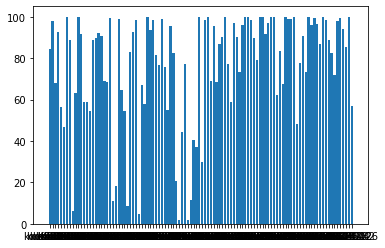

In [20]:
plt.bar(list(nan_percentages.keys()), nan_percentages.values())

In [21]:
path2ko_and_genes['path:ko00010']['ko:K00001']['aac'][0]

'Aaci_0920'

In [22]:
def get_seq(gene):
    seq = REST.kegg_get(gene, 'aaseq').read()
    seq = list(seq.split('\n'))
    seq = ''.join(seq[1:-1])
    return seq

In [23]:
# organism + gene
org = 'aac'
gene = 'Aaci_0920'
get_seq(org + ':' + gene)

'MQTRAAVLMEMGARPPYASTRPLRLETLELEPPGPGEVLIRVRAAGLCHSDLSVIEGARPRPMPMALGHEAAGEVVELGEGVTDLAPGDHVVCAFVPSCGHCAPCQEGRPALCEPGAEANGRGTLLSGARRLRLGGQPVHHHLGVSAFSDYAVVSRRSLVRIDPSLPFEHAALFGCAVMTGVGAIVNTARVPVGASVGIVGLGGVGLAALLGAVASSARHIAAIDVNPEKLAFARELGATHTYDARDPGVIDKVRADSAGGLEYVFETAGSVAAMKTAFMVTRRGGTTVTTGLPDPRHEWSVPQVLLAAEERTIRGSYVGSCIPSRDIPRFISLFQQGKLPVDRLVSDVIDLDHINEGFDRLAAGEAVRIVVRMSGA'

In [24]:
rt = RossmannToolbox()

/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/site-packages/rossmann_toolbox/rtb.py:55 - No GPU detected, falling back to the CPU version!
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/site-packages/rossmann_toolbox/rtb.py:66 - FoldX binary location was not provided. The structure-based prediction functionality will be disabled.
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/site-packages/rossmann_toolbox/rtb.py:75 - HHpred path was not provided. The HHsearch-based prediction of Rossmann cores won't be available
/Users/jedrzejkubica/desktop/python/anaconda/envs/myenv/lib/python3.7/site-packages/rossmann_toolbox/rtb.py:83 - DSSP binary location was not provided. The structure-based prediction functionality will be disabled.


In [25]:
data = {'3m6i_A': 'MASSASKTNIGVFTNPQHDLWISEASPSLESVQKGEELKEGEVTVAVRSTGICGSDVHFWKHGCIGPMIVECDHVLGHESAGEVIAVHPSVKSIKVGDRVAIEPQVICNACEPCLTGRYNGCERVDFLSTPPVPGLLRRYVNHPAVWCHKIGNMSYENGAMLEPLSVALAGLQRAGVRLGDPVLICGAGPIGLITMLCAKAAGACPLVITDIDEGRLKFAKEICPEVVTHKVERLSAEESAKKIVESFGGIEPAVALECTGVESSIAAAIWAVKFGGKVFVIGVGKNEIQIPFMRASVREVDLQFQYRYCNTWPRAIRLVENGLVDLTRLVTHRFPLEDALKAFETASDPKTGAIKVQIQSL'}

In [26]:
pred = rt.predict(data, mode='seq')

In [27]:
pred

{'3m6i_A': {'FAD': 0.0008948206,
  'FAD_std': 0.0017566498,
  'NAD': 0.9984492,
  'NAD_std': 0.003091433,
  'NADP': 0.00015440313,
  'NADP_std': 0.00028788683,
  'SAM': 0.00025481186,
  'SAM_std': 0.0004926439,
  'sequence': 'AGVRLGDPVLICGAGPIGLITMLCAKAAGACPLVITDIDEGRL'}}

In [31]:
data1 = {'aac:Aaci_0920': 'MQTRAAVLMEMGARPPYASTRPLRLETLELEPPGPGEVLIRVRAAGLCHSDLSVIEGARPRPMPMALGHEAAGEVVELGEGVTDLAPGDHVVCAFVPSCGHCAPCQEGRPALCEPGAEANGRGTLLSGARRLRLGGQPVHHHLGVSAFSDYAVVSRRSLVRIDPSLPFEHAALFGCAVMTGVGAIVNTARVPVGASVGIVGLGGVGLAALLGAVASSARHIAAIDVNPEKLAFARELGATHTYDARDPGVIDKVRADSAGGLEYVFETAGSVAAMKTAFMVTRRGGTTVTTGLPDPRHEWSVPQVLLAAEERTIRGSYVGSCIPSRDIPRFISLFQQGKLPVDRLVSDVIDLDHINEGFDRLAAGEAVRIVVRMSGAMQTRAAVLMEMGARPPYASTRPLRLETLELEPPGPGEVLIRVRAAGLCHSDLSVIEGARPRPMPMALGHEAAGEVVELGEGVTDLAPGDHVVCAFVPSCGHCAPCQEGRPALCEPGAEANGRGTLLSGARRLRLGGQPVHHHLGVSAFSDYAVVSRRSLVRIDPSLPFEHAALFGCAVMTGVGAIVNTARVPVGASVGIVGLGGVGLAALLGAVASSARHIAAIDVNPEKLAFARELGATHTYDARDPGVIDKVRADSAGGLEYVFETAGSVAAMKTAFMVTRRGGTTVTTGLPDPRHEWSVPQVLLAAEERTIRGSYVGSCIPSRDIPRFISLFQQGKLPVDRLVSDVIDLDHINEGFDRLAAGEAVRIVVRMSGA'}

In [32]:
pred1 = rt.predict(data1, mode='seq')

In [33]:
pred1

{'aac:Aaci_0920': {'FAD': 0.0006259757,
  'FAD_std': 0.0012491064,
  'NAD': 0.99930894,
  'NAD_std': 0.0012433289,
  'NADP': 1.1393373e-05,
  'NADP_std': 1.3443688e-05,
  'SAM': 0.00051817216,
  'SAM_std': 0.00085847604,
  'sequence': 'ARVPVGASVGIVGLGGVGLAALLGAVASSARHIAAIDVNPEKL'}}